In [1]:
import h5py
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_origin
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd
from dnb_annual import *
from variables import years, composites, region_map, region_names

c:\Users\jakub\anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\jakub\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [5]:
# this script is used only once to generate the regional images for each year
country_polygons = gpd.read_file("geoBoundaries-UKR-ADM1.geojson")

for year in years:
    dnb = dnb_annual(year, composites, country_polygons)
    dnb.load_all_data()
    dnb.save_rasters()
    dnb.load_rasters()
    dnb.build_regional_images()
    dnb.add_padding()
    dnb.save_regional_images()

In [31]:
# this script is used to clean gdp data

# Inflation data
# inflation = pd.read_excel("data/isc_reg.xls", skiprows=2, header=1)
# inflation = inflation.drop(columns=inflation.columns[0])
# inflation = inflation.rename(columns={inflation.columns[-1]: "region"})
# inflation = inflation[~inflation["region"].isin(["Ukraine", "oblasts"])]
# inflation = inflation.dropna()
# inflation["region"] = inflation["region"].map(region_map)
# inflation.columns = inflation.columns.astype(str)
# inflation = inflation.melt(id_vars="region", var_name="year", value_name="inflation")
# inflation.to_csv("data/inflation.csv", index=False)

# GDP data
gdp = pd.read_excel("data/ukr_reg_gdp.xls", skiprows=3, header=1)
gdp = gdp.drop(columns=gdp.columns[0])
gdp = gdp.iloc[:, np.r_[18:36, -1]]
gdp = gdp.rename(columns={gdp.columns[-1]: "region"})
gdp = gdp[~gdp["region"].isin(["Ukrane", "oblasts"])]
gdp = gdp.dropna()
gdp["region"] = gdp["region"].map(region_map)
gdp["region"] = gdp["region"].fillna("Sevastopol")
gdp.columns = gdp.columns.astype(str)
gdp = gdp.rename(columns={gdp.columns[i]: gdp.columns[i][:4] for i in range(18)})
gdp = gdp.melt(id_vars="region", var_name="year", value_name="real_gdp_change")

# include only years from 2012 inclusive, exclude Sevastopol and the Autonomous Republic of Crimea
gdp = gdp[gdp["year"].astype(int) >= 2012]
gdp = gdp[~gdp["region"].isin(["Sevastopol", "Autonomous Republic of Crimea"])]

# set the value for the starting year to 100 (2012), NaN for the rest
gdp.loc[gdp["year"] == "2012", "real_gdp"] = 100
gdp = gdp.sort_values(by=["region", "year"])
gdp["real_gdp_change"] = gdp["real_gdp_change"] / 100

# reste the index
gdp = gdp.reset_index(drop=True)

# calculate the real gdp

for i in range(1, gdp.shape[0]):

    # skip if the year is 2012
    if gdp.loc[gdp.index[i], "year"] == "2012":
        continue
    else:
        gdp.loc[gdp.index[i], "real_gdp"] = gdp.loc[gdp.index[i-1], "real_gdp"] * (gdp.loc[gdp.index[i], "real_gdp_change"])

# delete the real_gdp_change column
gdp = gdp.drop(columns="real_gdp_change")

# save the data
gdp.to_csv("data/clean_gdp.csv", index=False)


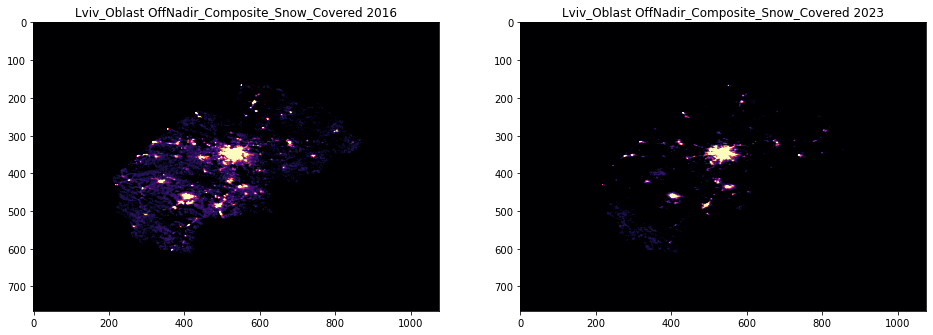

In [4]:
year1 = 2016
year2 = 2023
region_name = "Lviv_Oblast"
composite = "OffNadir_Composite_Snow_Covered"

# load the regional image h5 with padding for the first year
file_name1 = f"data/annual_region_images/{year1}_{region_name}.h5"
with h5py.File(file_name1, "r") as f1:
    data1 = f1[composite][:]

# load the regional image h5 with padding for the second year
file_name2 = f"data/annual_region_images/{year2}_{region_name}.h5"
with h5py.File(file_name2, "r") as f2:
    data2 = f2[composite][:]

# plot the images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot for the first year
im1 = ax1.imshow(data1, vmin=0, vmax=40, cmap="magma")
ax1.set_title(f"{region_name} {composite} {year1}")

# plot for the second year
im2 = ax2.imshow(data2, vmin=0, vmax=40, cmap="magma")
ax2.set_title(f"{region_name} {composite} {year2}")

plt.show()


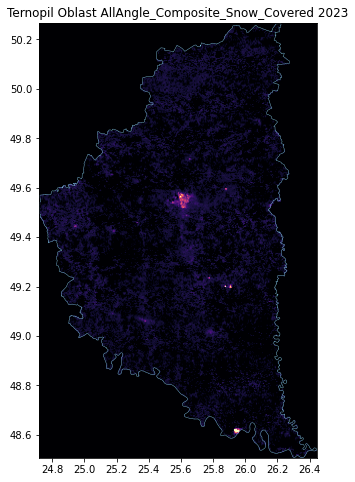

In [7]:
dnb_2023.plot_regional_image("AllAngle_Composite_Snow_Covered", "Ternopil Oblast")

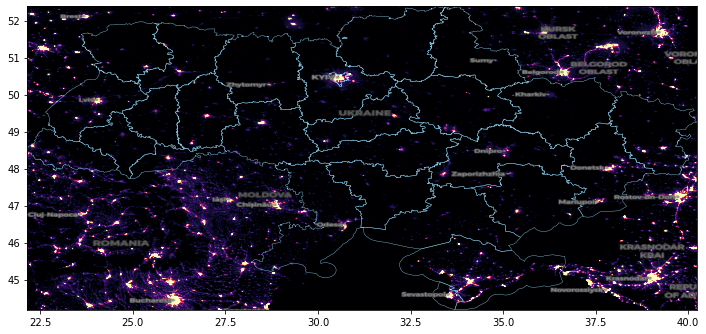

In [5]:
# plot lights for Ukraine in 2023

# load the shapefile, get the bounding box of Ukraine
ukraine_polygons = gpd.read_file("geoBoundaries-UKR-ADM1.geojson")
ukraine_bbox = ukraine_polygons.total_bounds

# read the raster file
raster = rasterio.open("intermediate_data/2023_Snow_Free_dnb.tif")
raster_window = raster.window(*ukraine_bbox)
raster_clipped = raster.read(1, window=raster_window)

# plot
fig , ax = plt.subplots(figsize =( 12 ,8))
im = ax.imshow(raster_clipped, extent = ukraine_bbox[[0, 2, 1, 3]], vmin=0, vmax=63, cmap="magma")
# State boundaries are overlayed
ukraine_polygons.boundary.plot(ax=ax, color="skyblue", linewidth=0.4)
cx.add_basemap(ax=ax, crs=ukraine_polygons.crs.to_string(), source = cx.providers.CartoDB.DarkMatterOnlyLabels , 
               attribution = False)